In [1]:
import os
print("PYTHONPATH is:", os.environ.get('PYTHONPATH', 'Not found'))


PYTHONPATH is: :/autofs/space/bal_004/users/jd1677/neurite-sandbox/:/autofs/space/bal_004/users/jd1677/voxelmorph-sandbox:/autofs/space/bal_004/users/jd1677/neurite


2023-10-31 11:30:15.286517: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/autofs/cluster/scratch/friday/javid/tensorflow_2.13.0-gpu-user-base/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Issue loading cv2
2023-10-31 11:30:23.900788: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0
2023-10-31 11:30:32.638461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded c

1/1 [==============================] - 0s 34ms/step


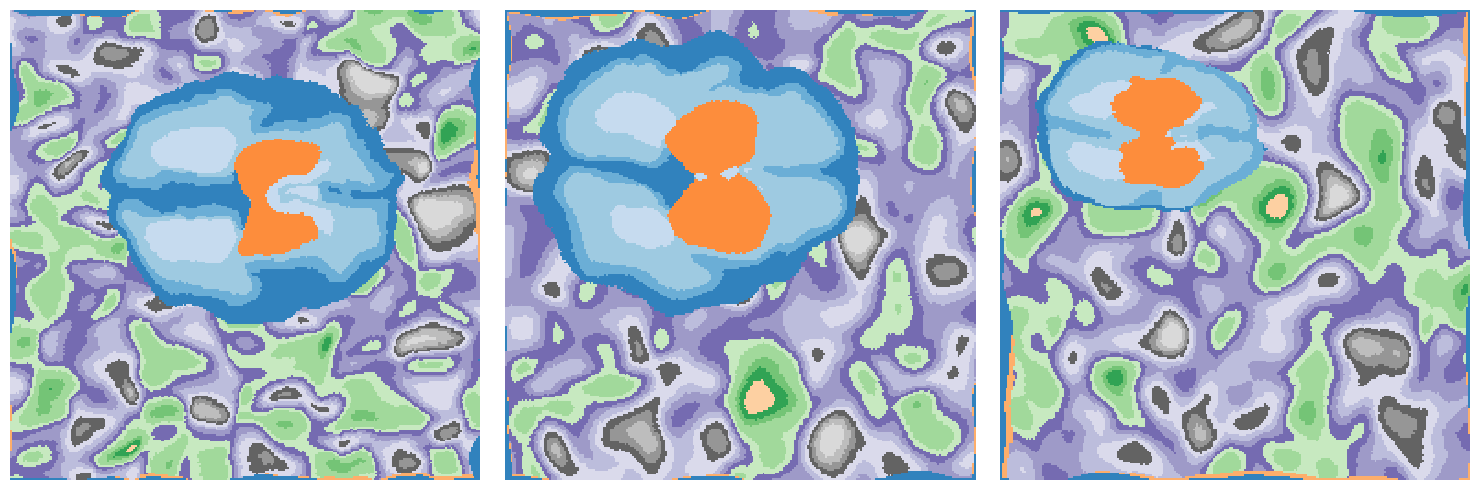

1/1 [==============================] - 0s 26ms/step


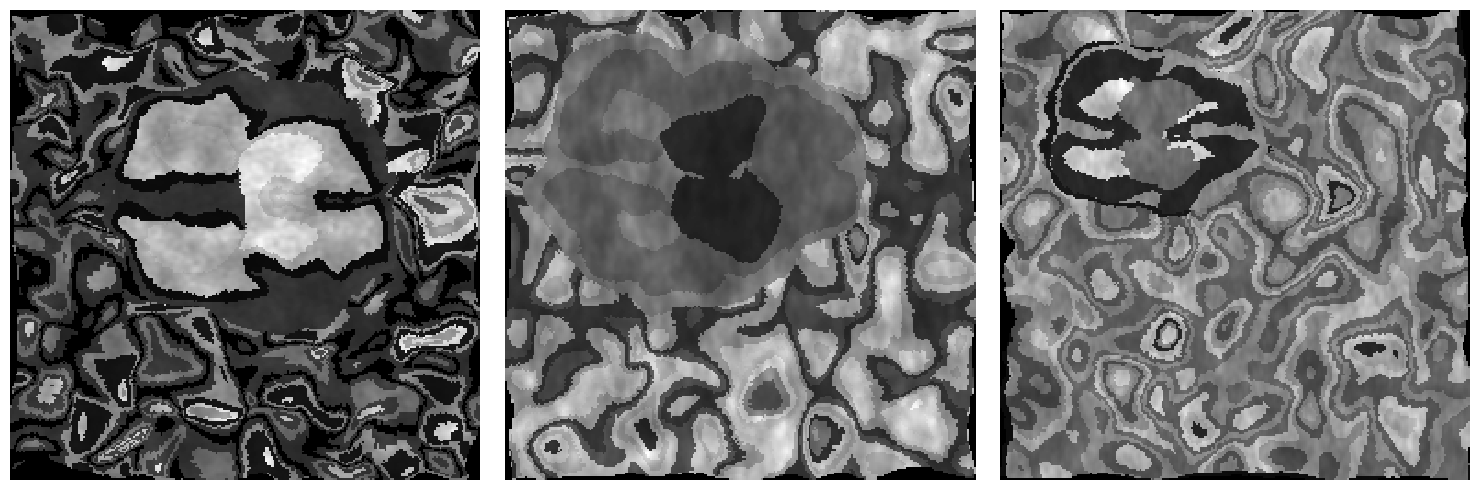

(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv
import tensorflow as tf
from tensorflow.keras.models import Model
from neurite.tf import models  # Assuming the module's location
import voxelmorph.tf.losses as vtml
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
import neurite as ne
import sys
import nibabel as nib
from tensorflow.keras.models import load_model
import numpy as np
import os
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full
# from neurite.tf.utils.augment import labels_to_labels
from tensorflow.keras.layers import Input, Lambda

# import ne.keras as nke
import tensorflow.keras.layers as KL
import voxelmorph as vxm

tf.get_logger().setLevel('ERROR')
log_dir='logs_feta_mom_brain'
models_dir='models_feta_mom_brain_param'
# checkpoint_path='weights_epoch_2300.h5'
data_dir = 'feta_2d/'

initial_epoch=0
nb_labels=8
dimx=256
dimy=256
nb_features=64
batch_size=4
warp_max=2   
warp_max=2.5
warp_min=.5
warp_blur_min=np.array([2, 4, 8])
warp_blur_max=warp_blur_min*2
bias_blur_min=np.array([2, 4, 8])
bias_blur_max=bias_blur_min*2
initial_lr=1e-4
lr = 1e-4
lr_lin = 1e-4
nb_levels=5
conv_size=3
num_epochs=40000
num_bg_labels=16
warp_fwhm_min=10
warp_fwhm_max=20
in_shape=(dimx,dimy)

gen_arg_labels_to_image = dict(
    in_shape=in_shape,
    warp_min=warp_min,
    warp_max=warp_max,
    one_hot=False,
    labels_in=[i for i in range(num_bg_labels+nb_labels)],
    blur_max=0.0,  # Set the blur to 0 for clearer shapes
    bias_max=0.25,  # Adjust the bias to the desired level
    bias_blur_min=bias_blur_min,
    bias_blur_max=bias_blur_max,
    gamma=0.0,
    zero_background=1,
    noise_max=0.0,
    noise_min=0.0
)
li = [i for i in range(nb_labels)]
gen_arg_labels_to_labels = dict(
    in_shape=(dimx, dimy),
    labels_in=li,
    shapes_add=True,  # Boolean indicating whether to replace the background with random shapes
    shapes_num=8,
    shapes_zero_max=0.0,
    shapes_fwhm_min=16,
    shapes_fwhm_max=64,
    shapes_warp_max=0.1,
    shapes_gen_scale=2,
)

def draw_shapes(
    shape, num_label=16, warp_min=1, warp_max=20, dtype=None, seed=None,
    image_fwhm_min=20, image_fwhm_max=40, warp_fwhm_min=40, warp_fwhm_max=80,
):
    # Data types.
    # shape=(dimx,dimy)
    type_fp = tf.float16
    type_int = tf.int32
    if dtype is None:
        dtype = tf.keras.mixed_precision.global_policy().compute_dtype
    dtype = tf.dtypes.as_dtype(dtype)

    # Randomization.
    rand = np.random.default_rng(seed)
    seed = lambda: rand.integers(np.iinfo(np.int32).max, dtype=np.int32)
    prop = lambda: dict(isotropic=False, batched=False, featured=True, seed=seed(), dtype=type_fp, reduce=tf.math.reduce_max)

    v = draw_perlin_full(
        shape=(*shape, 1),
        fwhm_min=image_fwhm_min, fwhm_max=image_fwhm_max, **prop(),
    )
    t = draw_perlin_full(
        shape=(*shape, len(shape)), noise_min=warp_min, noise_max=warp_max,
        fwhm_min=warp_fwhm_min, fwhm_max=warp_fwhm_max, **prop(),
    )

    # Application and background.
    v = ne.utils.minmax_norm(v)
    v = vxm.utils.transform(v, t, fill_value=-1)
    v = tf.floor(v * (num_label - 1))
    fg = tf.greater_equal(v, 0)
    out = (v + 1) * tf.cast(fg, v.dtype)

    return tf.cast(out, dtype) if out.dtype != dtype else out

def nothing_to_shapes(out_shape, **kwargs):
    nothing = Input(shape=[])
    generate = lambda _: draw_shapes(out_shape, **kwargs)
    return tf.keras.Model(
        inputs=nothing,
        outputs=Lambda(lambda x: tf.map_fn(generate, x))(nothing),
    )
    
class CustomTensorBoard(tf.keras.callbacks.TensorBoard):
    def __init__(self, base_log_dir, **kwargs):
        super(CustomTensorBoard, self).__init__(**kwargs)
        self.base_log_dir = base_log_dir

    def on_epoch_begin(self, epoch, logs=None):
        if epoch % 200 == 0:  # Check if it's the start of a new set of 50 epochs
            self.log_dir = f"{self.base_log_dir}/epoch_{epoch}"
            super().set_model(self.model)




class PeriodicWeightsSaver(tf.keras.callbacks.Callback):
    def __init__(self, filepath, save_freq=200, **kwargs):
        super().__init__(**kwargs)
        self.filepath = filepath
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs=None):
        # Save the weights every `save_freq` epochs
        if (epoch + 1) % self.save_freq == 0:
            # sys.stdout.close()
            # sys.stdout = old_stdout
            
            weights_path = os.path.join(self.filepath, f"weights_epoch_{epoch + 1}.h5")
            self.model.save_weights(weights_path)
            print(f"Saved weights to {weights_path}")
        else:
            self.old_stdout = sys.stdout
            sys.stdout = open(os.devnull, 'w')
            # sys.stdout.close()
            sys.stdout = self.old_stdout


weights_saver = PeriodicWeightsSaver(filepath=models_dir, save_freq=50)  # Save weights every 5 epochs

TB_callback = CustomTensorBoard(
    base_log_dir=log_dir,
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None
)


def dice_loss(y_true, y_pred):
    ndims = len(y_pred.get_shape().as_list()) - 2
    vol_axes = list(range(1, ndims + 1))
    # print(y_true.shape,y_pred.shape)
    top = 2 * tf.reduce_sum(y_true * y_pred, vol_axes)
    bottom = tf.reduce_sum(y_true + y_pred, vol_axes)

    div_no_nan = tf.math.divide_no_nan if hasattr(
        tf.math, 'divide_no_nan') else tf.div_no_nan  # pylint: disable=no-member
    dice = tf.reduce_mean(div_no_nan(top, bottom))
    return -dice
    
def dice_coefficient(y_true, y_pred):
    ndims = len(y_pred.get_shape().as_list()) - 2
    vol_axes = list(range(1, ndims + 1))

    top = 2 * tf.reduce_sum(y_true * y_pred, vol_axes)
    bottom = tf.reduce_sum(y_true + y_pred, vol_axes)

    div_no_nan = tf.math.divide_no_nan if hasattr(
    tf.math, 'divide_no_nan') else tf.div_no_nan  # pylint: disable=no-member
    dice = tf.reduce_mean(div_no_nan(top, bottom))
    return dice
    
def load_data(data_dir):
    
    subject_dirs = [d for d in os.listdir(data_dir) if d.startswith('sub-')]
    seg_image_filenames = []
    real_image_filenames = []
    fetal_data = []  # List to store fetal images
    fetal_segmentation_masks = []  # List to store fetal segmentation masks
    
    for subject_dir in subject_dirs:
        subject_prefix = subject_dir
    
        # Search for the T2-weighted image and segmented brain image with flexible naming patterns
        t2w_path = None
        dseg_path = None
        # print(os.path.join(data_dir, subject_prefix))
        for filename in os.listdir(os.path.join(data_dir, subject_prefix)):
            if "_T2w.nii.gz" in filename:
                t2w_path = os.path.join(data_dir, subject_prefix, filename)
            elif "_dseg.nii.gz" in filename:
                dseg_path = os.path.join(data_dir, subject_prefix, filename)
    
        if t2w_path is None or dseg_path is None:
            print(f"Data not found for subject {subject_prefix}. Skipping...")
            continue
    
        # Append the filenames to the respective lists
        real_image_filenames.append(t2w_path)
        seg_image_filenames.append(dseg_path)
        
    for i in range(len(real_image_filenames)):
        # Load the 2D image
        img_path = real_image_filenames[i]
        real_img = nib.load(img_path).get_fdata()

        seg_img_path = seg_image_filenames[i]
        seg_img = nib.load(seg_img_path).get_fdata()

        min_value = np.min(real_img)
        max_value = np.max(real_img)
        real_img = (real_img - min_value) / (max_value - min_value)

        real_img = tf.expand_dims(real_img, axis=0)  # Shape becomes (1, 160, 192, 1)
        fetal_data.append(real_img)
        fetal_segmentation_masks.append(seg_img)
    return fetal_data, fetal_segmentation_masks

fetal_data, fetal_segmentation_masks = load_data(data_dir)
X_train, X_test, y_train, y_test = train_test_split(fetal_data, fetal_segmentation_masks, test_size=0.2, random_state=42)

input_img = Input(shape=(dimx, dimy,1))

labels_to_image_model = ne.models.labels_to_image_new(**gen_arg_labels_to_image)#,input_model=labels_to_labels_model)
# max_label=20
def my_generator(label_maps, batch_size=1, same_subj=False, flip=False):
    in_shape = label_maps[0].shape
    
    num_dim = len(in_shape)
    void = np.zeros((batch_size, *in_shape), dtype='float32')
    rand = np.random.default_rng()
    prop = dict(replace=False, shuffle=False)
    num_batches = len(label_maps) // batch_size
    kwargs = {
    'num_label': num_bg_labels,
    'warp_min': warp_min,
    'warp_max': warp_max,
    'image_fwhm_max':20,
    'image_fwhm_min':10
    }
    # print(dim)
    while True:
        gen_model = nothing_to_shapes((dimx, dimy),**kwargs)
        shapes = gen_model.predict(np.ones((1,)))
        # shape = -shape-1 

        ind = rand.integers(len(label_maps), size=2 * batch_size)
        x = [label_maps[i] for i in ind]
        if same_subj:
            x = x[:batch_size] * 2
        x = np.stack(x)[..., None]

        if flip:
            axes = rand.choice(num_dim, size=rand.integers(num_dim + 1), **prop)
            x = np.flip(x, axis=axes + 1)

        labels_in = np.unique(x).astype(int)
        offset = tf.reduce_max(labels_in) + 1
        shapes += offset
        
        fg = x > 0
        combined = x * fg + shapes * (1 - fg)
        im, label_map = labels_to_image_model.predict(combined)
        src = label_map[:batch_size, ...,0]

        y = np.array(void)
        yield src, y


num_shapes = 3
combined_images=[]
combined_label_maps=[]
data_generator = my_generator(y_test, batch_size=1, same_subj=False, flip=False)
num_iterations = 3  # Set the number of iterations as needed
for i in range(num_iterations):
    src, y = next(data_generator)
    combined_label_maps.append(src)

ne.plot.slices([list(shape) for shape in combined_label_maps], cmaps=['tab20c'] * num_shapes)

for lm in combined_label_maps:
    lm = np.expand_dims(lm, axis=-1)
    model_1, label_map = labels_to_image_model.predict(lm)

    combined_images.append(np.squeeze(model_1,0))   
ne.plot.slices([list(image) for image in combined_images], cmaps=['gray'] * num_shapes)


using final_pred_activation softmax for unet
using final_pred_activation softmax for unet
1/1 [==============================] - 0s 39ms/step
(1, 256, 256)
1/1 [==============================] - 0s 25ms/step
(1, 256, 256)
1/1 [==============================] - 0s 27ms/step
(1, 256, 256)


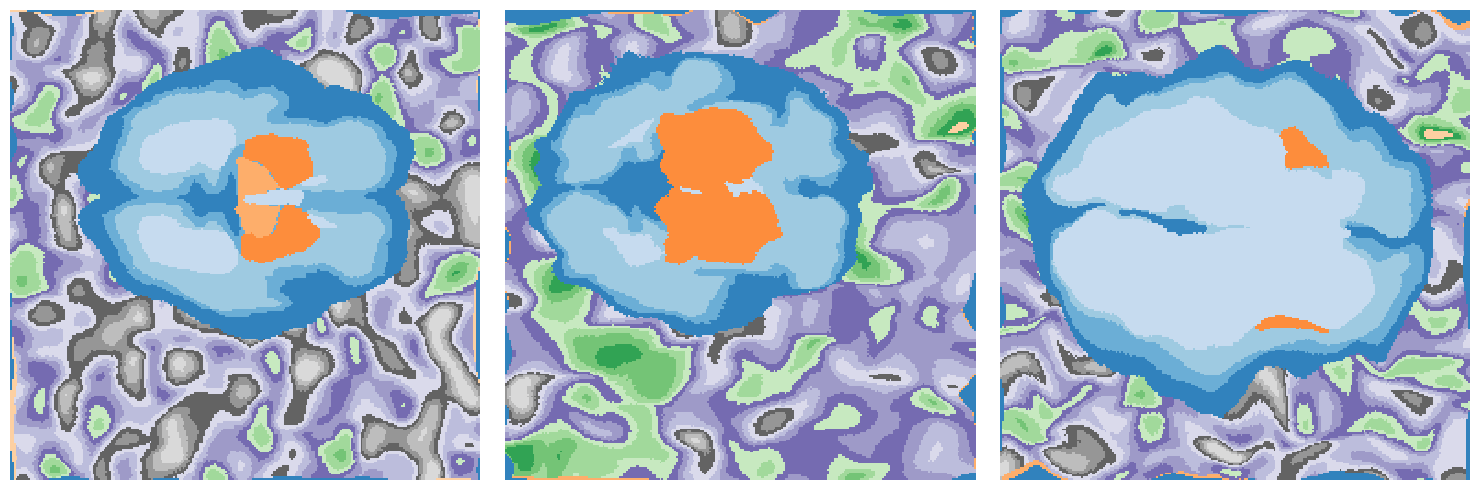

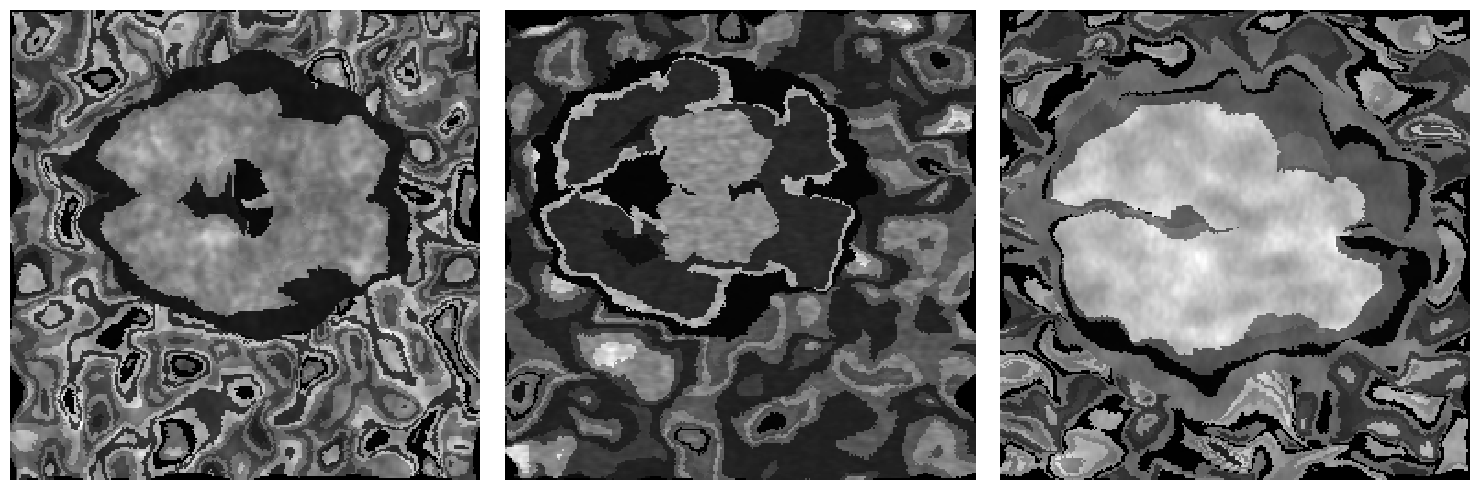

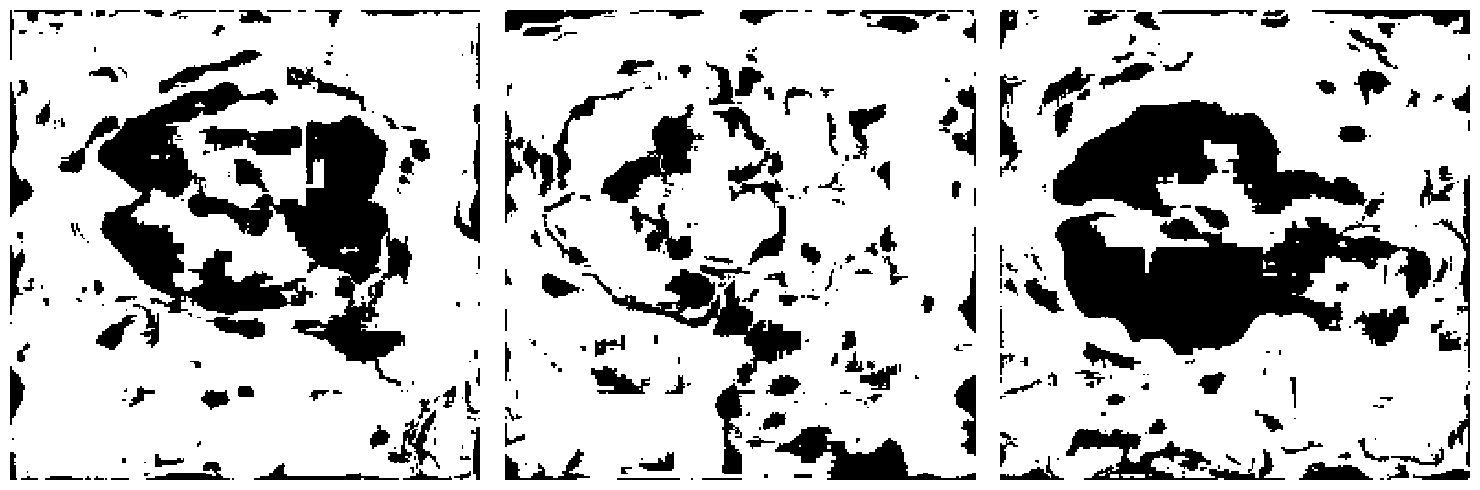

(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [13]:

   import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import csv
import tensorflow as tf
from tensorflow.keras.models import Model
from neurite.tf import models  # Assuming the module's location
import voxelmorph.tf.losses as vtml
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
import neurite as ne
import sys
import nibabel as nib
from tensorflow.keras.models import load_model
from neurite_sandbox.tf.models import labels_to_labels

tf.get_logger().setLevel('ERROR')
log_dir='logs_feta'
models_dir='models_feta_mom_brain'
checkpoint_path='weights_epoch_7000.h5'
data_dir = 'feta_2d/'

import numpy as np
nb_labels=2
dimx=256
dimy=256
nb_features=64
batch_size=8
warp_max=2   
warp_max=2.5
warp_min=.5
warp_blur_min=np.array([2, 4, 8])
warp_blur_max=warp_blur_min*2
bias_blur_min=np.array([2, 4, 8])
bias_blur_max=bias_blur_min*2
initial_lr=1e-4
lr = 1e-4
lr_lin = 1e-4
nb_levels=5
conv_size=3
num_epochs=40000
num_bg_labels=16

def dice_coefficient(y_true, y_pred):
    ndims = len(y_pred.get_shape().as_list()) - 2
    vol_axes = list(range(1, ndims + 1))

    top = 2 * tf.reduce_sum(y_true * y_pred, vol_axes)
    bottom = tf.reduce_sum(y_true + y_pred, vol_axes)

    div_no_nan = tf.math.divide_no_nan if hasattr(
    tf.math, 'divide_no_nan') else tf.div_no_nan  # pylint: disable=no-member
    dice = tf.reduce_mean(div_no_nan(top, bottom))
    return dice

def load_model(checkpoint):
    in_shape = (dimx,dimy)
    input_img = Input(shape=(dimx, dimy,1))
    gen_arg_labels_to_image = dict(
    in_shape=in_shape,
    warp_min=warp_min,
    warp_max=warp_max,
    one_hot=False,
    labels_in=[i for i in range(num_bg_labels+nb_labels)],
    blur_max=0.0,  # Set the blur to 0 for clearer shapes
    bias_max=0.25,  # Adjust the bias to the desired level
    bias_blur_min=bias_blur_min,
    bias_blur_max=bias_blur_max,
    gamma=0.0,
    zero_background=0.2,
    noise_max=0.0,
    noise_min=0.0
    )
    
    gen_arg_labels_to_labels = dict(
        in_shape=(dimx, dimy),
        labels_in=[i for i in range(nb_labels)],
    )

    labels_to_image_model = ne.models.labels_to_image_new(**gen_arg_labels_to_image)

    generated_img, y = labels_to_image_model(input_img)
    unet_model = models.unet(input_shape=(dimx, dimy, 1), nb_features=nb_features, nb_labels=2, nb_levels=nb_levels, conv_size=conv_size)
    segmentation = unet_model(generated_img)
    combined_model = Model(inputs=input_img, outputs=segmentation)
    
    combined_model.load_weights(os.path.join(models_dir,checkpoint))
    
    unet_from_combined = combined_model.get_layer('unet') # Make sure the name matches the U-Net layer's name in the combined model
    unet_from_combined.save_weights(models_dir+'/unet_only_weights.h5')
    
    unet_model = models.unet(input_shape=(dimx, dimy, 1), nb_features=nb_features, nb_labels=2, nb_levels=nb_levels, conv_size=conv_size)
    unet_model.load_weights(models_dir+'/unet_only_weights.h5')
    return unet_model
    
fetal_data, fetal_segmentation_masks = load_data(data_dir)
X_train, X_test, y_train, y_test = train_test_split(fetal_data, fetal_segmentation_masks, test_size=0.2, random_state=42)

unet_model = load_model(checkpoint_path)

train_dice_coefficients = []
test_dice_coefficients = []

y_preds=[]


num_shapes = 3
combined_images=[]
combined_label_maps=[]
data_generator = my_generator(y_train, batch_size=1, same_subj=False, flip=False)
num_iterations = 3  # Set the number of iterations as needed
for i in range(num_iterations):
    src, y = next(data_generator)
    combined_label_maps.append(src)


for lm in combined_label_maps:
    lm = np.expand_dims(lm, axis=-1)
    generated_img, y = labels_to_image_model.predict(lm)
    
    generated_img = tf.expand_dims(generated_img, axis=-1)  # Shape becomes (1, dimx, dimy, 1)
    segmentation = unet_model.predict(generated_img, verbose=0)

    
    print(y_pred.shape)
    segmentation = tf.argmax(segmentation, axis=-1, output_type=tf.int32)
    combined_images.append(generated_img)
    y_preds.append(segmentation)


# for i in range(num_shapes):
ne.plot.slices([list(shape) for shape in combined_label_maps], cmaps=['tab20c'] * num_shapes)
ne.plot.slices(slices_in=([combined_images[i] for i in range(num_shapes)]), cmaps=['gray', 'gray', 'gray'])
ne.plot.slices(slices_in=([y_preds[i] for i in range(num_shapes)]), cmaps=['gray', 'gray', 'gray'])
    